# I. Setup

In [50]:
import psutil

mem = psutil.virtual_memory()
total_gb = mem.total / (1024 ** 3)
available_gb = mem.available / (1024 ** 3)

print(f"Total RAM: {total_gb:.2f} GB")
print(f"Available RAM: {available_gb:.2f} GB")


Total RAM: 15.84 GB
Available RAM: 2.85 GB


In [51]:
import os
os.environ['HADOOP_HOME'] = "C:\\hadoop"

# II. Import Data

In [52]:
from pyspark.sql import SparkSession


spark = (SparkSession.builder
         .appName("KIN HOTEL PROJECT")
         .master("local[*]")
         .config("spark.executor.memory", "2g")
         .config("spark.driver.memory", "2g")
         .config("spark.sql.shuffle.partitions", "2")
         .getOrCreate())


In [53]:
from pyspark.sql.types import *

# Link: https://www.kaggle.com/datasets/kartikeybartwal/ecomerce-product-recommendation-dataset?resource=download
schema = StructType([
    StructField("Number of clicks on similar products", IntegerType(), True),
    StructField("Number of similar products purchased so far", IntegerType(), True),
    StructField("Average rating given to similar products", FloatType(), True),
    StructField("Gender", StringType(), True),
    StructField("Median purchasing price (in rupees)", IntegerType(), True),
    StructField("Rating of the product", FloatType(), True),
    StructField("Brand of the product", StringType(), True),
    StructField("Customer review sentiment score (overall)", FloatType(), True),
    StructField("Price of the product", FloatType(), True),
    StructField("Holiday", StringType(), True),
    StructField("Season", StringType(), True),
    StructField("Geographical locations", StringType(), True),
    StructField("Probability for the product to be recommended to the person", FloatType(), True),
])

In [54]:
file_path = r"E:\Learn-Cloud-\PySpark - Flink\content_based_recommendation_dataset.csv"

df = spark.read.csv(file_path, 
                   header=True, 
                   schema=schema,
                   sep = ',')

df.show(5,0)

+------------------------------------+-------------------------------------------+----------------------------------------+------+-----------------------------------+---------------------+--------------------+-----------------------------------------+--------------------+-------+-------+----------------------+-----------------------------------------------------------+
|Number of clicks on similar products|Number of similar products purchased so far|Average rating given to similar products|Gender|Median purchasing price (in rupees)|Rating of the product|Brand of the product|Customer review sentiment score (overall)|Price of the product|Holiday|Season |Geographical locations|Probability for the product to be recommended to the person|
+------------------------------------+-------------------------------------------+----------------------------------------+------+-----------------------------------+---------------------+--------------------+-----------------------------------------+-----

In [55]:
# Display options examples:

# 1. Standard display - will truncate long strings
print("Standard display:")
df.show(3)

# 2. No truncation - shows full content of all fields
print("\nNo truncation:")
df.show(3, truncate=False)

# 3. Vertical display - each record shown vertically (great for many columns)
print("\nVertical display:")
df.show(2, vertical=True)

# 4. Combined - vertical with no truncation
print("\nVertical with no truncation:")
df.show(2, truncate=False, vertical=True)

# 5. Custom width truncation (limit to 10 characters)
print("\nCustom width truncation (10 chars):")
df.show(3, truncate=10)

Standard display:
+------------------------------------+-------------------------------------------+----------------------------------------+------+-----------------------------------+---------------------+--------------------+-----------------------------------------+--------------------+-------+-------+----------------------+-----------------------------------------------------------+
|Number of clicks on similar products|Number of similar products purchased so far|Average rating given to similar products|Gender|Median purchasing price (in rupees)|Rating of the product|Brand of the product|Customer review sentiment score (overall)|Price of the product|Holiday| Season|Geographical locations|Probability for the product to be recommended to the person|
+------------------------------------+-------------------------------------------+----------------------------------------+------+-----------------------------------+---------------------+--------------------+-----------------------------

# III. Exploratory data analysis

In [56]:
# Let’s start by counting the number of rows in the DataFram :
print("\nNumber of rows in the DataFrame:")
row_count = df.count()
print(row_count)
print("\nNumber of columns in the DataFrame:")
columns_count = len(df.columns)
print(columns_count)



Number of rows in the DataFrame:
1474

Number of columns in the DataFrame:
13


In [57]:
# Rename all the columns for better calling later
df = df.withColumnRenamed("Number of clicks on similar products", "clicks") \
       .withColumnRenamed("Number of similar products purchased so far", "purchased") \
       .withColumnRenamed("Average rating given to similar products", "avg_rating") \
       .withColumnRenamed("Gender", "gender") \
       .withColumnRenamed("Median purchasing price (in rupees)", "median_price") \
       .withColumnRenamed("Rating of the product", "product_rating") \
       .withColumnRenamed("Brand of the product", "brand") \
       .withColumnRenamed("Customer review sentiment score (overall)", "sentiment_score") \
       .withColumnRenamed("Price of the product", "price") \
       .withColumnRenamed("Holiday", "holiday") \
       .withColumnRenamed("Season", "season") \
       .withColumnRenamed("Geographical locations", "location") \
       .withColumnRenamed("Probability for the product to be recommended to the person", "recommendation_prob")


In [58]:
# How many unique brand are present in the DataFrame?
df.select("brand"). distinct().count()

48

In [59]:
# Checking for null values in each columns
from pyspark.sql.functions import *

df.select([sum(col(c).isNull().cast("int")).alias(c +"_null_count") for c in df.columns]).show()
df.dropna().count()

+-----------------+--------------------+---------------------+-----------------+-----------------------+-------------------------+----------------+--------------------------+----------------+------------------+-----------------+-------------------+------------------------------+
|clicks_null_count|purchased_null_count|avg_rating_null_count|gender_null_count|median_price_null_count|product_rating_null_count|brand_null_count|sentiment_score_null_count|price_null_count|holiday_null_count|season_null_count|location_null_count|recommendation_prob_null_count|
+-----------------+--------------------+---------------------+-----------------+-----------------------+-------------------------+----------------+--------------------------+----------------+------------------+-----------------+-------------------+------------------------------+
|                0|                   0|                    0|                0|                      0|                        0|               0|             

1474

In [60]:
# Checking for duplicate rows
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Showing some duplicate rows
df.groupBy(df.columns).count().filter("count>1").orderBy("count", ascending = False).show()

# Dropping duplicate rows
df = df.dropDuplicates()
print(f"Number of rows after dropping duplicates: {df.count()}")

Number of duplicate rows: 456
+------+---------+----------+------+------------+--------------+--------------------+---------------+-----+-------+------+---------+-------------------+-----+
|clicks|purchased|avg_rating|gender|median_price|product_rating|               brand|sentiment_score|price|holiday|season| location|recommendation_prob|count|
+------+---------+----------+------+------------+--------------+--------------------+---------------+-----+-------+------+---------+-------------------+-----+
|    16|        8|       3.8|female|         900|           4.0|   Johnson & Johnson|            0.7|200.0|     No|summer|   plains|                0.8|   19|
|     8|        4|       3.2|  male|        3000|           3.4|            Fastrack|            0.2|400.0|     No|winter|   plains|                0.3|   19|
|    11|        5|       3.2|female|        4000|           3.4|Patanjali Ayurved...|            0.1|500.0|    Yes|winter|   plains|                0.2|   19|
|    12|        

In [61]:
# Counting the distribution of Gender, count and percentage
df.select("gender").distinct().show()
df.groupBy("gender").count().show()

# Advanced PySpark Caculations
total_count = df.count()
print("\nDetailed Gender Distribution:")
df.groupBy("gender")\
.agg(count("*").alias("count"))\
.withColumn("percentage", round(col("count")/total_count *100,2))\
.withColumn("formatted", concat(col("count"), lit(" ("), col("percentage"), lit("% )")))\
.select("gender", "count", "percentage", "formatted")\
.orderBy("count", ascending=False) \
.show()

+------+
|gender|
+------+
|female|
|  male|
+------+

+------+-----+
|gender|count|
+------+-----+
|female|  503|
|  male|  515|
+------+-----+


Detailed Gender Distribution:
+------+-----+----------+-------------+
|gender|count|percentage|    formatted|
+------+-----+----------+-------------+
|  male|  515|     50.59|515 (50.59% )|
|female|  503|     49.41|503 (49.41% )|
+------+-----+----------+-------------+



In [62]:
# Basic Statistics in Price
df.describe("price").show()
mean_price = df.select(mean("price")).collect()[0][0]

# Calculating the average price of products group by brand
df.groupBy("brand")\
.agg(round(mean("price"),2).alias("avg_price")) \
.withColumn("vs_avg_price",round((col("avg_price")/mean_price)*100,2)) \
.withColumn("formatted_avg_price",
            concat(col("vs_avg_price"), lit("%"))) \
.withColumn("above_or_below_avg",
            when(col("avg_price") > mean_price, "Above Average")
    .when(col("avg_price") < mean_price, "Below Average")
    .otherwise("Average")) \
.select("brand", "avg_price", "formatted_avg_price", "above_or_below_avg") \
.orderBy("avg_price", ascending=True) \
.show(10, truncate=False)

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              1018|
|   mean|1334.9214145383105|
| stddev|2126.9896564710098|
|    min|              90.0|
|    max|           10000.0|
+-------+------------------+

+---------------------+---------+-------------------+------------------+
|brand                |avg_price|formatted_avg_price|above_or_below_avg|
+---------------------+---------+-------------------+------------------+
|Stayfree             |223.08   |16.71%             |Below Average     |
|Whisper              |375.0    |28.09%             |Below Average     |
|Sugar Cosmetics      |433.33   |32.46%             |Below Average     |
|Libram               |491.67   |36.83%             |Below Average     |
|Johnson & Johnson    |535.0    |40.08%             |Below Average     |
|Zandu                |550.0    |41.2%              |Below Average     |
|U.S. Polo Assn. Women|575.0    |43.07%             |Below Average     |
|Lee    

In [63]:
# Calculating the number of products in each brand and the average rating of products in each brand
df.groupBy("brand")\
.agg(count("*").alias("product_count"),
        round(mean("product_rating"), 2).alias("avg_rating")) \
.withColumn("rating_vs_avg",
            round((col("avg_rating")/df.select(mean("product_rating")).collect()[0][0])*100, 2)) \
.withColumn("formatted_rating_vs_avg",
            concat(col("rating_vs_avg"), lit("%"))) \
.withColumn("above_or_below_avg_rating",
            when(col("avg_rating") > df.select(mean("product_rating")).collect()[0][0], "Above Average")
            .when(col("avg_rating") < df.select(mean("product_rating")).collect()[0][0], "Below Average")
            .otherwise("Average")) \
.select("brand", "product_count", "avg_rating", "formatted_rating_vs_avg", "above_or_below_avg_rating") \
.orderBy("product_count", ascending=False) \
.show(10, truncate=False)

+-------------------------------+-------------+----------+-----------------------+-------------------------+
|brand                          |product_count|avg_rating|formatted_rating_vs_avg|above_or_below_avg_rating|
+-------------------------------+-------------+----------+-----------------------+-------------------------+
|Wildcraft                      |74           |4.24      |105.7%                 |Above Average            |
|Manyavar Mohey                 |58           |4.0       |99.72%                 |Below Average            |
|Pepperfry                      |55           |4.11      |102.46%                |Above Average            |
|Flying Machine                 |52           |3.86      |96.23%                 |Below Average            |
|Patanjali Ayurved (Health Care)|50           |4.17      |103.96%                |Above Average            |
|Lee                            |46           |4.35      |108.45%                |Above Average            |
|Lakme Ayurveda    

In [64]:
mean_price = df.selectExpr("avg(price)").first()[0]
df.filter(f"price > {mean_price}").agg({"recommendation_prob": "avg"}).show()
df.filter(f"price <= {mean_price}").agg({"recommendation_prob": "avg"}).show()


+------------------------+
|avg(recommendation_prob)|
+------------------------+
|      0.8444055873197276|
+------------------------+

+------------------------+
|avg(recommendation_prob)|
+------------------------+
|      0.6253199996000954|
+------------------------+



## IV. Data Preprocessing

In [65]:
df = df.withColumn("Customer_ID", monotonically_increasing_id())
columns = df.columns

new_orders = ["Customer_ID"] + [c for c in columns if c != "Customer_ID"]
df = df.select(new_orders)

In [66]:
start_date = "2023-01-01"
end_date = "2023-12-31"

df = df.withColumn(
    "Date",
    expr(
        "date_add("
        f"'{start_date}', "
        "cast(floor(rand() * datediff('{end}', '{start}')) as int)"
        ")"
        .replace("{start}", start_date)
        .replace("{end}", end_date)
    )
)

columns = df.columns
new_orders = ["Customer_ID", "Date"] + [c for c in columns if c not in ["Customer_ID", "Date"]]
df = df.select(new_orders)


In [75]:
current_date = "2023-12-31"
df = df.withColumn("Recency", datediff(lit(current_date), df["Date"])) \
        .withColumn("Recency", col("Recency").cast(IntegerType())) \
        .withColumn("Monetary", expr("price * purchased").cast(FloatType()))
rfm = df.groupBy("Customer_ID") \
    .agg(
        max("Recency").alias("Recency"),
        sum("Monetary").alias("Monetary"),
        count("Customer_ID").alias("Frequency")
    )
rfm.show(5, truncate=False) 

+-----------+-------+--------+---------+
|Customer_ID|Recency|Monetary|Frequency|
+-----------+-------+--------+---------+
|2          |289    |300.0   |1        |
|4          |358    |2700.0  |1        |
|5          |119    |8000.0  |1        |
|8          |275    |5400.0  |1        |
|12         |246    |7200.0  |1        |
+-----------+-------+--------+---------+
only showing top 5 rows


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembeler = VectorAssembler(
    inputCols=["Recency", "Monetary", "Frequency"],
    outputCol="features"
)
assembeler_data = assembeler.transform(rfm)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=False
)
scaler_data = scaler.fit(assembeler_data).transform(assembeler_data)

scaler_data.select("scaled_features").show(5, truncate=False)


+---------------------------------------------+
|scaled_features                              |
+---------------------------------------------+
|[2.7804486017092063,0.008073323922524769,0.0]|
|[3.4442927315290515,0.07265991530272292,0.0] |
|[1.144890600703791,0.21528863793399383,0.0]  |
|[2.6457555898617016,0.14531983060544584,0.0] |
|[2.366748636749013,0.19375977414059445,0.0]  |
+---------------------------------------------+
only showing top 5 rows


In [79]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='scaled_features', k=i)
    KMeans_fit=KMeans_algo.fit(scaler_data)
    output=KMeans_fit.transform(scaler_data)
    cost[i] = KMeans_fit.summary.trainingCost

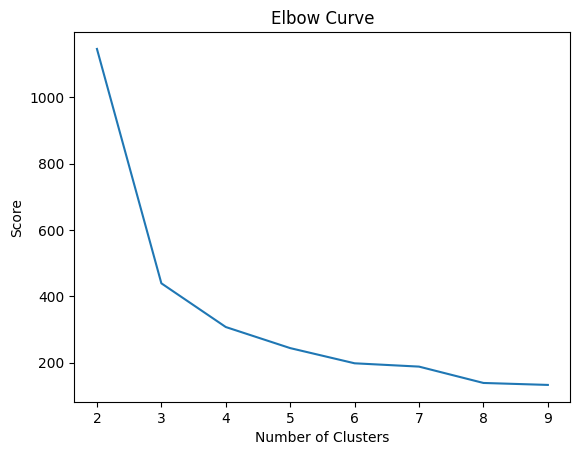

In [80]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [82]:
KMeans_algo=KMeans(featuresCol='scaled_features', k=3)
KMeans_fit=KMeans_algo.fit(scaler_data)

In [83]:
preds=KMeans_fit.transform(scaler_data)

preds.show(5,0)

+-----------+-------+--------+---------+------------------+---------------------------------------------+----------+
|Customer_ID|Recency|Monetary|Frequency|features          |scaled_features                              |prediction|
+-----------+-------+--------+---------+------------------+---------------------------------------------+----------+
|2          |289    |300.0   |1        |[289.0,300.0,1.0] |[2.7804486017092063,0.008073323922524769,0.0]|1         |
|4          |358    |2700.0  |1        |[358.0,2700.0,1.0]|[3.4442927315290515,0.07265991530272292,0.0] |1         |
|5          |119    |8000.0  |1        |[119.0,8000.0,1.0]|[1.144890600703791,0.21528863793399383,0.0]  |0         |
|8          |275    |5400.0  |1        |[275.0,5400.0,1.0]|[2.6457555898617016,0.14531983060544584,0.0] |1         |
|12         |246    |7200.0  |1        |[246.0,7200.0,1.0]|[2.366748636749013,0.19375977414059445,0.0]  |1         |
+-----------+-------+--------+---------+------------------+-----

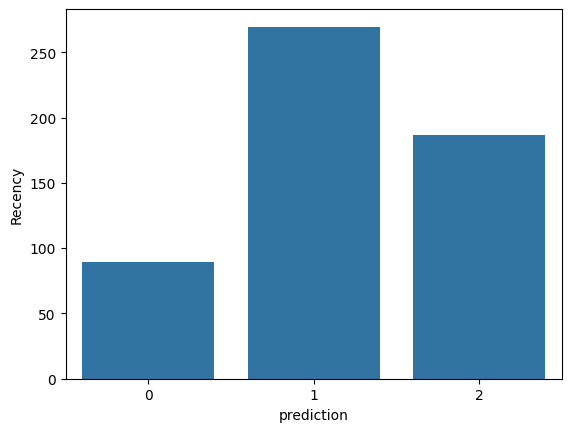

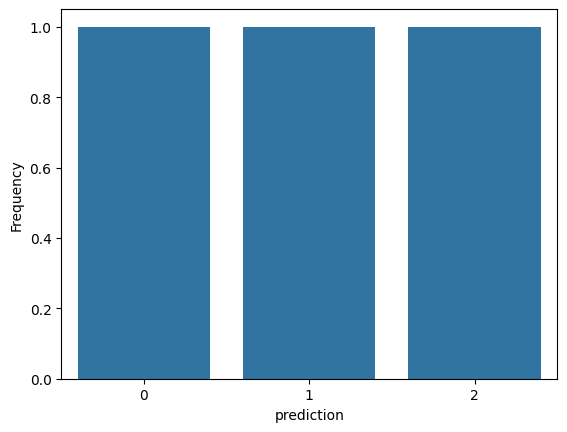

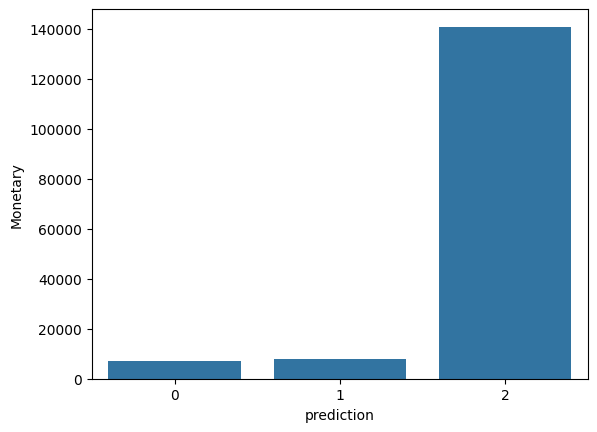

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('Recency','Frequency','Monetary','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['Recency','Frequency','Monetary']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()